# Regime Model 2 Testing

## Objective
This notebook tests an enhanced regime classification model using 3 selected features:

1. **Returns**: Captures the market's direction.
2. **NFCI (National Financial Conditions Index)**: Comprehensive indicator of overall financial stress, encompassing credit spreads and volatility.
3. **Stock-Bond Correlation**: Differentiates between market corrections and systemic crises by measuring hedging effectiveness.

## Rationale
- **NFCI over Credit/Volatility**: NFCI is a composite index that already includes credit spreads and volatility, offering a more robust and less redundant measure of current financial stress.
- **Correlation for Tail Risk**: The stock-bond correlation identifies true tail-risk events where both asset classes decline, signaling a systemic crisis.


In [1]:
# --- Imports ---
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tqdm import tqdm

print("All libraries imported successfully.")

All libraries imported successfully.


## 1. Advanced Regime Classifier

This classifier uses the enhanced 3-variable feature set:
- **Returns**: Log returns of SPY.
- **NFCI**: National Financial Conditions Index from FRED.
- **Correlation**: Rolling correlation between SPY and TLT returns (stock-bond correlation).

In [2]:
class AdvancedRegimeClassifier:
    """
    Advanced Regime Classifier using Returns, NFCI, and Stock-Bond Correlation.
    
    Features:
    - Returns: Log returns of SPY (market direction)
    - NFCI: Comprehensive financial stress indicator
    - Correlation: SPY-TLT rolling correlation (hedging effectiveness)
    """
    
    def __init__(self, start_date='1993-02-01', end_date='2024-12-31', 
                 n_states=3, min_window=60, corr_window=12):
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.min_window = min_window
        self.corr_window = corr_window  # Rolling window for correlation calculation
    
    def fetch_data(self):
        """Fetch SPY, TLT, and NFCI data, then engineer features."""
        print(">>> 1. Fetching Data & Calculating Features...")
        
        # --- A. Market Data (SPY & TLT) ---
        spy = yf.download(
            'SPY',
            start=self.start_date,
            end=self.end_date,
            interval='1mo',
            progress=False,
            auto_adjust=True
        )['Close']
        
        # TLT (iShares 20+ Year Treasury Bond ETF) - started trading in 2002
        tlt = yf.download(
            'TLT',
            start='2002-07-01',  # TLT inception date
            end=self.end_date,
            interval='1mo',
            progress=False,
            auto_adjust=True
        )['Close']
        
        # Handle potential DataFrame format
        if isinstance(spy, pd.DataFrame):
            spy = spy.iloc[:, 0]
        if isinstance(tlt, pd.DataFrame):
            tlt = tlt.iloc[:, 0]
        
        # Align indices to month-end
        spy.index = spy.index.to_period('M').to_timestamp('M')
        tlt.index = tlt.index.to_period('M').to_timestamp('M')
        
        # --- B. Feature Engineering ---
        spy_returns = np.log(spy / spy.shift(1))
        tlt_returns = np.log(tlt / tlt.shift(1))
        
        # Rolling Correlation between SPY and TLT
        correlation = spy_returns.rolling(window=self.corr_window).corr(tlt_returns)
        
        # --- C. Macro Data (FRED: NFCI) ---
        nfci = web.DataReader(
            'NFCI',
            'fred',
            '2002-07-01',  # Align with TLT start
            self.end_date
        ).resample('M').last()
        
        nfci.index = nfci.index.to_period('M').to_timestamp('M')
        
        # --- D. Merge All Data ---
        df = pd.DataFrame({
            'SPY': spy,
            'TLT': tlt,
            'Returns': spy_returns,
            'Correlation': correlation
        })
        
        df = df.join(nfci).ffill().dropna()
        
        print(f"    Data Shape: {df.shape}")
        print(f"    Date Range: {df.index[0].strftime('%Y-%m')} to {df.index[-1].strftime('%Y-%m')}")
        print(f"    Features: Returns, NFCI, Correlation")
        
        return df
    
    def run_expanding_window_hmm(self, df):
        """Run HMM with expanding window using the advanced feature set."""
        print(">>> 2. Running Expanding Window HMM (Advanced Features)...")
        
        regime_preds = []
        prob_preds = []
        
        # Key change: using Returns, NFCI, Correlation as features
        feature_cols = ['Returns', 'NFCI', 'Correlation']
        
        for t in tqdm(range(self.min_window, len(df))):
            
            train_data = df.iloc[:t + 1].copy()
            X_train = train_data[feature_cols].values
            
            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds
            
            best_score = -np.inf
            best_model = None
            
            # Multiple random initializations for stability
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)
                    
                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue
            
            if best_model is None:
                best_model = model
            
            hidden_states = best_model.predict(X_scaled)
            current_state = hidden_states[-1]
            current_probs = best_model.predict_proba(X_scaled)[-1]
            
            # --- Dynamic State Re-ordering ---
            # Logic: Higher NFCI + Higher Correlation (less hedging) = More Crisis-like
            state_scores = []
            
            # Weights: NFCI is primary, Correlation secondary, Returns tertiary
            w_nfci = 0.5   # NFCI: positive = tighter financial conditions
            w_corr = 0.3  # Correlation: higher = less hedging benefit (more crisis)
            w_ret = 0.2   # Returns: lower = more crisis-like
            
            for i in range(self.n_states):
                m = best_model.means_[i]
                
                # m[0] = Returns, m[1] = NFCI, m[2] = Correlation
                score = (
                    w_nfci * m[1] +       # Higher NFCI = more crisis
                    w_corr * m[2] -       # Higher correlation = less hedging = more crisis
                    w_ret  * m[0]         # Lower returns = more crisis
                )
                state_scores.append((i, score))
            
            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}
            
            final_regime = mapping[current_state]
            sorted_indices = [old for old, _ in sorted_states]
            final_probs = current_probs[sorted_indices]
            
            regime_preds.append(final_regime)
            prob_preds.append(final_probs)
        
        result_index = df.index[self.min_window:]
        res_df = pd.DataFrame(index=result_index)
        res_df['Regime'] = regime_preds
        res_df[['Prob_Bull', 'Prob_Uncertain', 'Prob_Crisis']] = prob_preds
        
        return df.join(res_df).dropna()
    
    def visualize(self, df):
        """Visualize regimes with all three features."""
        print(">>> 3. Visualizing Regimes...")
        
        fig, ax = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
        
        colors = ['#2ca02c', '#ff7f0e', '#d62728']
        labels = ['Bull (Risk-On)', 'Uncertain', 'Crisis (Risk-Off)']
        
        # --- Plot 1: SPY Price with Regime Colors ---
        for i in range(3):
            mask = df['Regime'] == i
            ax[0].scatter(
                df.index[mask],
                df['SPY'][mask],
                s=15,
                c=colors[i],
                label=labels[i],
                alpha=0.7
            )
        
        ax[0].set_title('SPY Price Colored by Advanced Regime (Returns, NFCI, Correlation)', fontsize=12)
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)
        ax[0].set_ylabel('SPY Price (Log)')
        
        # --- Plot 2: Probability of Crisis ---
        ax[1].plot(df.index, df['Prob_Crisis'], 'r-', alpha=0.8)
        ax[1].fill_between(df.index, 0, df['Prob_Crisis'], color='red', alpha=0.1)
        ax[1].axhline(0.5, linestyle='--', color='gray', alpha=0.5)
        ax[1].set_title('Probability of Crisis State', fontsize=12)
        ax[1].set_ylabel('Probability')
        ax[1].set_ylim(0, 1)
        ax[1].grid(True, alpha=0.3)
        
        # --- Plot 3: NFCI ---
        ax[2].plot(df.index, df['NFCI'], color='purple', alpha=0.8)
        ax[2].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[2].fill_between(df.index, 0, df['NFCI'], where=df['NFCI'] > 0, 
                          color='red', alpha=0.3, label='Tighter Conditions')
        ax[2].fill_between(df.index, 0, df['NFCI'], where=df['NFCI'] < 0, 
                          color='green', alpha=0.3, label='Looser Conditions')
        ax[2].set_title('NFCI (National Financial Conditions Index)', fontsize=12)
        ax[2].set_ylabel('NFCI')
        ax[2].legend(loc='upper left')
        ax[2].grid(True, alpha=0.3)
        
        # --- Plot 4: Stock-Bond Correlation ---
        ax[3].plot(df.index, df['Correlation'], color='blue', alpha=0.8)
        ax[3].axhline(0, linestyle='--', color='black', alpha=0.5)
        ax[3].fill_between(df.index, 0, df['Correlation'], where=df['Correlation'] > 0, 
                          color='red', alpha=0.3, label='Positive (Less Hedging)')
        ax[3].fill_between(df.index, 0, df['Correlation'], where=df['Correlation'] < 0, 
                          color='green', alpha=0.3, label='Negative (Good Hedging)')
        ax[3].set_title('SPY-TLT Rolling Correlation (12-month)', fontsize=12)
        ax[3].set_ylabel('Correlation')
        ax[3].set_xlabel('Date')
        ax[3].legend(loc='upper left')
        ax[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("AdvancedRegimeClassifier class defined successfully.")

AdvancedRegimeClassifier class defined successfully.


## 2. Run the Advanced Model

In [3]:
# Initialize and run the advanced classifier
advanced_classifier = AdvancedRegimeClassifier(
    start_date='1993-02-01',
    end_date='2024-12-31',
    n_states=3,
    min_window=60,
    corr_window=12  # 12-month rolling correlation
)

# Fetch data with new features
df_advanced = advanced_classifier.fetch_data()

# Display sample data
print("\n[Sample Data]")
df_advanced.head(10)

>>> 1. Fetching Data & Calculating Features...
    Data Shape: (258, 5)
    Date Range: 2003-07 to 2024-12
    Features: Returns, NFCI, Correlation

[Sample Data]


,SPY,TLT,Returns,Correlation,NFCI
Date,,,,,
2003-07-31,65.591835,38.937664,0.021473,-0.312085,-0.71371
2003-08-31,66.944733,39.416660,0.020416,-0.321945,-0.67043
2003-09-30,65.961411,41.760391,-0.014798,-0.267271,-0.68348
2003-10-31,69.758865,40.506203,0.055975,-0.224162,-0.71793
2003-11-30,70.520706,40.646790,0.010862,-0.206907,-0.71771
2003-12-31,73.720490,40.966923,0.044374,-0.062636,-0.72625
2004-01-31,75.533142,42.131420,0.024291,-0.059608,-0.78870
2004-02-29,76.558197,42.915588,0.013480,-0.008729,-0.81694
2004-03-31,75.280197,43.525414,-0.016834,-0.074530,-0.80538


In [4]:
# Run HMM with advanced features
labeled_df_advanced = advanced_classifier.run_expanding_window_hmm(df_advanced)

print("\n[HMM Results]")
labeled_df_advanced[['SPY', 'Returns', 'NFCI', 'Correlation', 'Regime', 'Prob_Crisis']].tail(10)

>>> 2. Running Expanding Window HMM (Advanced Features)...


  0%|          | 0/198 [00:00<?, ?it/s]  File "c:\Users\Jun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Jun\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jun\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\User


[HMM Results]


,SPY,Returns,NFCI,Correlation,Regime,Prob_Crisis
Date,,,,,,
2024-03-31,510.451019,0.029076,-0.43455,0.790704,1.0,3.705527e-06
2024-04-30,491.391907,-0.038053,-0.41574,0.816486,1.0,3.851966e-10
2024-05-31,516.246399,0.049342,-0.41303,0.822944,1.0,1.667093e-11
2024-06-30,532.740906,0.031451,-0.38609,0.844389,1.0,1.289213e-06
2024-07-31,540.931519,0.015257,-0.36682,0.851105,1.0,1.310652e-11
2024-08-31,553.570557,0.023097,-0.39564,0.845392,1.0,1.826140e-11
2024-09-30,563.469849,0.017725,-0.43068,0.782432,2.0,1.000000e+00
2024-10-31,560.154663,-0.005901,-0.44650,0.765515,2.0,1.000000e+00
2024-11-30,593.558594,0.057923,-0.47714,0.638234,2.0,1.000000e+00


>>> 3. Visualizing Regimes...


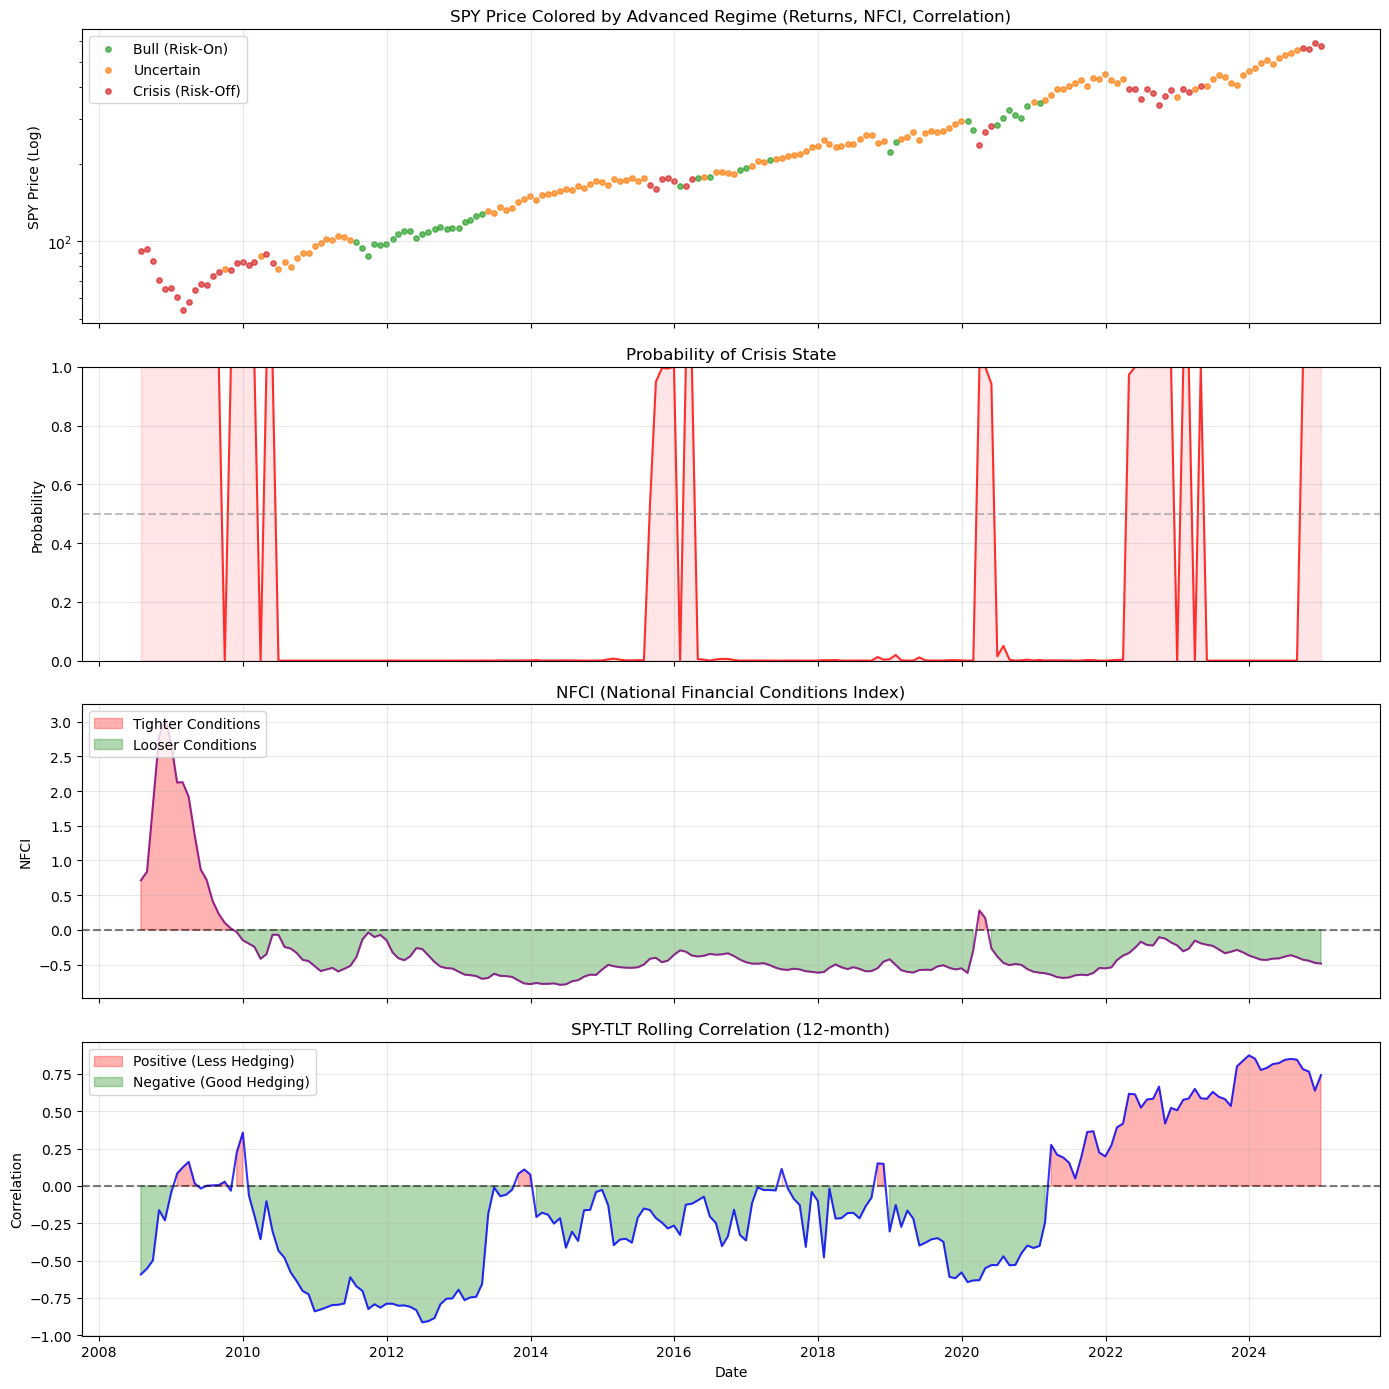

In [5]:
# Visualize the results
advanced_classifier.visualize(labeled_df_advanced)

## 3. Regime Statistics & Analysis

In [6]:
# Regime statistics
print("=" * 60)
print("ADVANCED REGIME MODEL STATISTICS")
print("Features: Returns, NFCI, Correlation")
print("=" * 60)

# Regime distribution
regime_counts = labeled_df_advanced['Regime'].value_counts().sort_index()
regime_pct = (regime_counts / len(labeled_df_advanced) * 100).round(1)

print("\n[Regime Distribution]")
regime_names = {0: 'Bull (Risk-On)', 1: 'Uncertain', 2: 'Crisis (Risk-Off)'}
for regime, count in regime_counts.items():
    print(f"  {regime_names[regime]}: {count} months ({regime_pct[regime]}%)")

# Feature characteristics by regime
print("\n[Feature Characteristics by Regime]")
for regime in [0, 1, 2]:
    mask = labeled_df_advanced['Regime'] == regime
    subset = labeled_df_advanced[mask]
    print(f"\n  {regime_names[regime]}:")
    print(f"    Avg Returns:     {subset['Returns'].mean()*100:.2f}% per month")
    print(f"    Avg NFCI:        {subset['NFCI'].mean():.3f}")
    print(f"    Avg Correlation: {subset['Correlation'].mean():.3f}")

print("\n[Latest Regime Status]")
latest = labeled_df_advanced.iloc[-1]
print(f"  Date: {labeled_df_advanced.index[-1].strftime('%Y-%m')}")
print(f"  Current Regime: {regime_names[int(latest['Regime'])]}")
print(f"  Crisis Probability: {latest['Prob_Crisis']:.2%}")

ADVANCED REGIME MODEL STATISTICS
Features: Returns, NFCI, Correlation

[Regime Distribution]
  Bull (Risk-On): 39 months (19.7%)
  Uncertain: 113 months (57.1%)
  Crisis (Risk-Off): 46 months (23.2%)

[Feature Characteristics by Regime]

  Bull (Risk-On):
    Avg Returns:     0.88% per month
    Avg NFCI:        -0.425
    Avg Correlation: -0.606

  Uncertain:
    Avg Returns:     1.43% per month
    Avg NFCI:        -0.525
    Avg Correlation: -0.053

  Crisis (Risk-Off):
    Avg Returns:     -0.26% per month
    Avg NFCI:        0.299
    Avg Correlation: 0.092

[Latest Regime Status]
  Date: 2024-12
  Current Regime: Crisis (Risk-Off)
  Crisis Probability: 100.00%


## 4. Crisis Period Analysis

Let's examine how well the model detected known crisis periods.

In [7]:
# Known crisis periods
crisis_periods = [
    ('2008 Financial Crisis', '2008-09', '2009-03'),
    ('COVID-19 Crash', '2020-02', '2020-04'),
    ('2022 Rate Hike', '2022-06', '2022-10'),
]

print("[Crisis Detection Analysis]")
print("="*60)

for crisis_name, start, end in crisis_periods:
    try:
        mask = (labeled_df_advanced.index >= start) & (labeled_df_advanced.index <= end)
        crisis_data = labeled_df_advanced[mask]
        
        if len(crisis_data) > 0:
            avg_prob_crisis = crisis_data['Prob_Crisis'].mean()
            regime_mode = crisis_data['Regime'].mode().values[0]
            pct_crisis = (crisis_data['Regime'] == 2).mean() * 100
            
            print(f"\n{crisis_name} ({start} to {end}):")
            print(f"  Avg Crisis Probability: {avg_prob_crisis:.2%}")
            print(f"  % Time in Crisis State: {pct_crisis:.1f}%")
            print(f"  Dominant Regime: {regime_names[regime_mode]}")
    except:
        print(f"\n{crisis_name}: Data not available for this period.")

[Crisis Detection Analysis]

2008 Financial Crisis (2008-09 to 2009-03):
  Avg Crisis Probability: 100.00%
  % Time in Crisis State: 100.0%
  Dominant Regime: Crisis (Risk-Off)

COVID-19 Crash (2020-02 to 2020-04):
  Avg Crisis Probability: 49.94%
  % Time in Crisis State: 50.0%
  Dominant Regime: Bull (Risk-On)

2022 Rate Hike (2022-06 to 2022-10):
  Avg Crisis Probability: 100.00%
  % Time in Crisis State: 100.0%
  Dominant Regime: Crisis (Risk-Off)
